实验二 隐形眼镜类型的预测

实验目标

1 理解信息熵和信息增益的概念。

2 掌握使用信息增益方法选取划分属性的方法。

3 理解决策树的表示方法。

4 掌握创建决策树的递归算法。

实验内容

使用现成的隐形眼镜数据集，使用决策树模拟眼科医生如何判断患者需要佩戴的镜片类型。具体包括以下参考步骤：

1 导入隐形眼镜数据集，并分为训练集和验证集。

2 编写程序实现信息熵的计算、划分属性的选择以及数据集的划分等过程。

3 编程实现决策树的创建。

4 编程实现利用决策树进行决策的方法。

5 选取合适的评价指标对决策结果进行评价。

6 选做：输出决策树树形。

3  实验目标

1 针对实验内容，梳理实验步骤、划分实验模块。

2 分析每个实验模块，完成对应模块的代码编写（含注释）和调试。

3 显示实验结果，并对实验结果进行对比分析，最后总结实验结果。

4 以实验笔记的形式撰写实验报告，可以包括实验内容，实验平台，采用的算法原理（简要介绍），采用的数据集，采用的评价指标，实验步骤，实验结果展示，实验比较与分析，实验总结，以及心得体会等等。


In [403]:
import numpy as np
from math import log
import operator
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']

In [404]:
# 计算给定数据集的香农熵
def calcShannonEnt(dataSet):
    # 获取数据集的样本数量
    numEntries = len(dataSet)
    # 定义一个字典，用于存储每个类别的出现次数
    labelCounts = {}
    # 对数据集的每一行进行遍历
    for featVec in dataSet:
        currentLabel = featVec[-1]  # 最后一行是label,获取当前样本的类别标签
        
        # 初始化，将当前类别标签加入字典
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1  # 统计当前类别标签的数量
    ShannonEnt = 0.0
    # 计算香农熵
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries  # 计算当前类别的概率
        ShannonEnt -= prob * log(prob, 2)  # 利用信息熵的公式进行累加计算
    return ShannonEnt

In [405]:
#按照给定的特征 划分数据集
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value: #将符合特征的数据抽取出来
            reducedFeatVec = featVec[:axis]#截取从0到选定的axis的各项分类信息
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)#重组一个新的dataset
    return retDataSet

In [406]:
#选取最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) -1#dataset[0] 代表索引为0的的第一行数据
    baseEntropy = calcShannonEnt(dataSet)#整个数据集的香农熵
    bestInfoGain = 0.0;#初始化
    bestFeature = -1
    for i in range(numFeatures):#循环遍历所有特征
        featList = [example[i] for example in dataSet] #先提取一行dataSet的数据，然后取该行数据的第“ i ”位元素。然后遍历每一行，最后获得一整列数据，变为一个列表list。
        uniqueVals = set(featList) #set()创建一个无序不重复元素集
        newEntropy = 0.0
        for value in uniqueVals: #计算每种划分方式的信息熵
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob*calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy#信息增益是熵的减少或者是数据无序度的减少
        if(infoGain > bestInfoGain): #计算最好的信息增益
            bestInfoGain = infoGain
            bestFeature = i
    
    return bestFeature,bestInfoGain

In [407]:
#如果数据集已经处理了所有属性，但是类标签依旧不唯一，则采用多数表决的方法决定叶子节点的分类
def majorityCount(classList):
    classCount = {} #创建键值为ClassList中唯一值的数据字典，字典对象储存了classList中每个类标签出现的频率，最后利用operator操作键值排序字典
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)#key=operator.itemgetter(1) 即获取对象的第1个域的值，即统计数
    return sortedClassCount[0][0]

In [408]:
#利用数据集和标签列表创建树
def createTree(dataSet,  labels):
    classList = [example[-1] for example in dataSet] #取最后一列
    if classList.count(classList[0]) == len(classList): #list自带的count函数，来统计list中每个元素出现的次数，如果类别完全相同则停止继续划分
        return classList[0]
    if len(dataSet[0]) == 1: #特征属性用完了但是还没有完全分开，多数表决
        return majorityCount(classList)
    bestFeat,bestInfoGain = chooseBestFeatureToSplit(dataSet)
    print(f"数据集的信息熵是{calcShannonEnt(dataSet)},数据集长度为{len(dataSet)}")
    print(f"最好的特征是{lensesLabels[bestFeat]},信息增益是{bestInfoGain}")

    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}#初始化# 注：labels列表是可变对象，在PYTHON函数中作为参数时传址引用，能够被全局修改
    # 所以这行代码导致函数外的同名变量被删除了元素，造成例句无法执行，提示'no surfacing' is not in list
    del(labels[bestFeat]) #del删除的是变量，而不是数据，当前数据集选取的最好特征存储在变量bestFeat中
    featValues = [example[bestFeat] for example in dataSet] #得到列表包含的所有属性值
    uniqueVals = set(featValues)
    for value in uniqueVals:#在每个数据集划分上递归调用函数createTree()
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat,value), subLabels)#递归调用
    return myTree

In [409]:
#绘制带箭头的注解
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', xytext=centerPt, textcoords='axes fraction',
                            va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)

decisionNode = dict(boxstyle="sawtooth", fc="cornflowerblue")
leafNode = dict(boxstyle="round4", fc="lightblue")
arrow_args = dict(arrowstyle="<-",linewidth=2)

In [410]:
#创建绘图区，计算树形图的全局尺寸
def createPlot(inTree):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon = False, **axprops)    #no ticks
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

In [411]:
#获取叶节点的数目
def getNumLeafs(myTree):#遍历整棵树，累计叶子节点的个数，并返回该数值，dick.keys()以列表返回一个字典所有的键
    numLeafs = 0
    firstStr = list(myTree.keys())[0]#书错 TypeError: 'dict_keys' object does not support indexing,返回的是dict_keys对象,支持iterable 但不支持indexable，我们可以将其明确的转化成list
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':#测试节点数据类型是否为字典
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

In [412]:
#获取树的层数
def getTreeDepth(myTree):
    depth = 0.0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > depth:
            depth = thisDepth
    return depth

In [413]:
#标注有向边属性
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]#children point
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

In [414]:
def plotTree(myTree, parentPt, nodeTxt):
    # 获取当前树的叶节点数和深度
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    # 获取当前树的根节点信息
    firstStr = list(myTree.keys())[0]
    print(f"当前属性是:{firstStr}")
    # 计算当前节点在 x 轴上的位置
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    # 在箭头中间位置添加文本信息
    plotMidText(cntrPt, parentPt, nodeTxt)
    # 绘制当前节点
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    # 获取当前节点的子节点信息
    secondDict = myTree[firstStr]
    # 更新 y 轴的偏移量
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    # 遍历子节点
    for key in secondDict.keys():
        print(f"对于当前属性若取值为:{str(key)}")
        if type(secondDict[key]).__name__ == 'dict':  # 判断子节点是否为字典，如果是则继续递归
            print("则进一步进行划分,")
            plotTree(secondDict[key], cntrPt, str(key))  # 递归调用
        else:  # 如果是叶节点，则绘制叶节点，并在箭头上添加文本信息
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            print(f"则抵达叶节点,对隐形眼镜的分类是:{str(secondDict[key])}")
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    # 恢复 y 轴的偏移量
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

In [415]:
def classify_lenses(tree, test_sample):
    """
    对测试样本进行分类
    :param tree: 决策树字典
    :param test_sample: 测试样本
    :return: 分类结果
    """
    if not isinstance(tree, dict):
        # 如果 tree 不是字典，表示已经是叶节点，返回叶节点值
        return tree
    root_label = list(tree.keys())[0]
    
    # 获取测试样本中根节点特征的取值
    root_value = test_sample[lensesLabels.index(root_label)]
    if root_value not in tree[root_label]:
        # 如果测试样本中的值在决策树中没有对应的分支，则返回默认值
        return 'unknown'
    
    next_branch = tree[root_label][root_value]
    return classify_lenses(next_branch, test_sample)

In [416]:
# 从 lenses.txt 读取数据
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate', 'label']

In [417]:
# 将数据转换为 DataFrame
df = pd.DataFrame(lenses, columns=lensesLabels)

# 将数据集划分为特征和标签
X = df.iloc[:, :-1]  # 特征
y = df.iloc[:, -1]   # 标签

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# 将特征和标签重新转换为列表
train_data = pd.concat([X_train, y_train], axis=1).values.tolist()
test_data = pd.concat([X_test, y_test], axis=1).values.tolist()

# 使用训练数据创建决策树
myTree_lenses = createTree(train_data, lensesLabels)
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']

数据集的信息熵是1.0529815751302694,数据集长度为15
最好的特征是tearRate,信息增益是0.3768676117918498
数据集的信息熵是1.4488156357251847,数据集长度为7
最好的特征是age,信息增益是0.6617049208213366
数据集的信息熵是0.9182958340544896,数据集长度为3
最好的特征是age,信息增益是0.2516291673878229
数据集的信息熵是1.0,数据集长度为2
最好的特征是age,信息增益是1.0
数据集的信息熵是0.9182958340544896,数据集长度为3
最好的特征是prescript,信息增益是0.9182958340544896


当前属性是:tearRate
对于当前属性若取值为:normal
则进一步进行划分,
当前属性是:age
对于当前属性若取值为:presbyopic
则进一步进行划分,
当前属性是:prescript
对于当前属性若取值为:myope
则进一步进行划分,
当前属性是:astigmatic
对于当前属性若取值为:yes
则抵达叶节点,对隐形眼镜的分类是:hard
对于当前属性若取值为:no
则抵达叶节点,对隐形眼镜的分类是:no lenses
对于当前属性若取值为:hyper
则抵达叶节点,对隐形眼镜的分类是:no lenses
对于当前属性若取值为:pre
则抵达叶节点,对隐形眼镜的分类是:no lenses
对于当前属性若取值为:young
则进一步进行划分,
当前属性是:astigmatic
对于当前属性若取值为:yes
则抵达叶节点,对隐形眼镜的分类是:hard
对于当前属性若取值为:no
则抵达叶节点,对隐形眼镜的分类是:soft
对于当前属性若取值为:reduced
则抵达叶节点,对隐形眼镜的分类是:no lenses


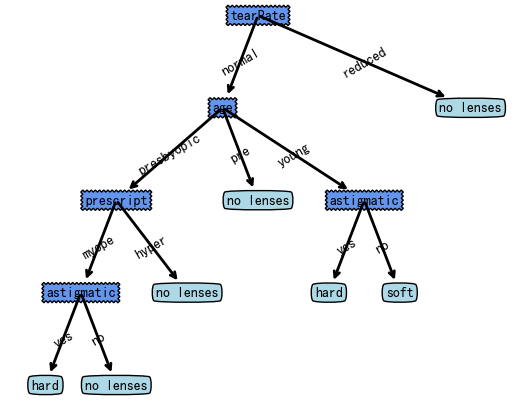

In [418]:
createPlot(myTree_lenses)

In [419]:
# 读取测试数据
test_file = open('test_data.txt')
test_data = [inst.strip().split('\t') for inst in test_file.readlines()]
count=0
predict_true=0
# 测试每个样本
for sample in test_data:
    count+=1
    # 获取样本的真实标签
    true_label = sample[-1]
    # 使用训练好的决策树进行分类
    predicted_label = classify_lenses(myTree_lenses, sample[:-1])
    if(true_label==predicted_label):
        predict_true+=1
    # 输出预测结果
    print(f"第{count}个测试样本的真实标签: {true_label}, 预测标签: {predicted_label}")
print(f"精度为:{predict_true/count}")

第1个测试样本的真实标签: no lenses, 预测标签: no lenses
第2个测试样本的真实标签: no lenses, 预测标签: no lenses
第3个测试样本的真实标签: no lenses, 预测标签: no lenses
第4个测试样本的真实标签: no lenses, 预测标签: no lenses
第5个测试样本的真实标签: no lenses, 预测标签: no lenses
第6个测试样本的真实标签: hard, 预测标签: hard
第7个测试样本的真实标签: no lenses, 预测标签: no lenses
第8个测试样本的真实标签: soft, 预测标签: no lenses
第9个测试样本的真实标签: no lenses, 预测标签: no lenses
第10个测试样本的真实标签: no lenses, 预测标签: no lenses
精度为:0.9
